<a href="https://colab.research.google.com/github/AvrodeepPal/SARIMA_Avro_Riju/blob/main/SUPER_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Column names in the dataset:
Index(['Warehouse id', 'Region', 'SKU id', 'Apr-18', 'May-18', 'Jun-18',
       'Jul-18', 'Aug-18', 'Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19',
       'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19',
       'Sep-19', 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20', 'Mar-20',
       'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20',
       'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21'],
      dtype='object')


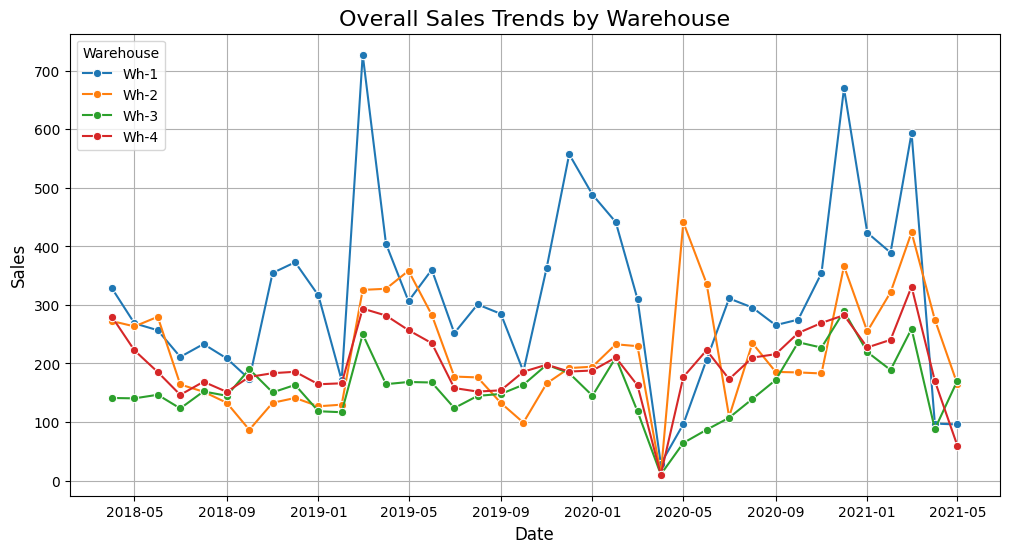

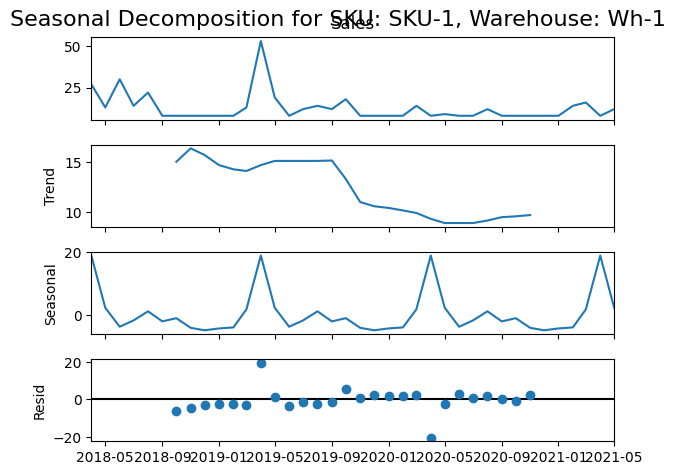

The file 'Submission.csv' has been created successfully with the forecasts.
The file 'Model_Errors.csv' has been generated successfully.


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings('ignore')

# Load the data
file_path = 'Data.csv'
submission_format_path = 'Submission-Format.csv'
data = pd.read_csv(file_path)

# Display the column names
print("Column names in the dataset:")
print(data.columns)

# Melt the dataset to long format
date_columns = data.columns[3:]  # Columns starting from 'Apr-18' to 'May-21'
data_long = pd.melt(
    data,
    id_vars=['Warehouse id', 'Region', 'SKU id'],
    value_vars=date_columns,
    var_name='Date',
    value_name='Sales'
)

# Rename columns for clarity
data_long.rename(columns={'Warehouse id': 'Warehouse', 'SKU id': 'SKU'}, inplace=True)

# Convert the 'Date' column to a proper datetime format
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%b-%y')

# Sort the data
data_long = data_long.sort_values(by=['Warehouse', 'SKU', 'Date'])

# Fill missing sales with 0
data_long['Sales'] = data_long['Sales'].fillna(0)

# Aggregating data by SKU and warehouse
agg_data = data_long.groupby(['Date', 'Warehouse', 'SKU', 'Region'])['Sales'].sum().reset_index()

# Plot Overall Sales Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_long, x='Date', y='Sales', hue='Warehouse', ci=None, marker='o')
plt.title('Overall Sales Trends by Warehouse', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(title='Warehouse', loc='upper left')
plt.grid()
plt.show()

# Seasonal Decomposition for an Example SKU and Warehouse
example_sku = agg_data['SKU'].iloc[0]
example_warehouse = agg_data['Warehouse'].iloc[0]
example_data = agg_data[(agg_data['SKU'] == example_sku) & (agg_data['Warehouse'] == example_warehouse)]
time_series = example_data.set_index('Date')['Sales']

# Ensure sufficient data points for decomposition
if len(time_series) >= 24:
    decomposition = seasonal_decompose(time_series, model='additive', period=12)
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition for SKU: {example_sku}, Warehouse: {example_warehouse}', fontsize=16)
    plt.show()
else:
    print(f"Not enough data points for seasonal decomposition for SKU: {example_sku}, Warehouse: {example_warehouse}")

# Forecasting for all SKU-Warehouse combinations
forecasts = []
errors = []  # List to store model errors

for warehouse in agg_data['Warehouse'].unique():
    for sku in agg_data['SKU'].unique():
        # Prepare the time series data
        time_series = agg_data[(agg_data['Warehouse'] == warehouse) &
                               (agg_data['SKU'] == sku)].set_index('Date')['Sales'].resample('M').sum()
        time_series = time_series.fillna(0)  # Handle missing data

        # Skip empty time series
        if time_series.empty:
            forecasts.append({'Warehouse id': warehouse, 'Region': None, 'SKU id': sku, 'Jun-21': np.nan})
            errors.append({'Warehouse id': warehouse, 'SKU id': sku, 'MAPE': np.nan,
                           'Details': 'No data available for this SKU-Warehouse combination.'})
            continue

        # Train-test split: Use data until May 2021 for training
        train_data = time_series[:'2021-05']

        if train_data.empty:
            forecasts.append({'Warehouse id': warehouse, 'Region': None, 'SKU id': sku, 'Jun-21': np.nan})
            errors.append({'Warehouse id': warehouse, 'SKU id': sku, 'MAPE': np.nan,
                           'Details': 'No training data available.'})
            continue

        # Fit SARIMA model
        try:
            model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                            enforce_stationarity=False, enforce_invertibility=False)
            sarima_fit = model.fit(disp=False)

            # Forecast for June 2021
            forecast = sarima_fit.forecast(steps=1).iloc[0]
            forecasts.append({'Warehouse id': warehouse, 'Region': None, 'SKU id': sku, 'Jun-21': forecast})

            # Evaluate model performance on training data
            predictions = sarima_fit.fittedvalues
            mape = mean_absolute_percentage_error(train_data, predictions)
            errors.append({'Warehouse id': warehouse, 'SKU id': sku, 'MAPE': mape, 'Details': 'Forecast successful'})
        except Exception as e:
            print(f"Failed to forecast for SKU: {sku}, Warehouse: {warehouse}. Error: {e}")
            forecasts.append({'Warehouse id': warehouse, 'Region': None, 'SKU id': sku, 'Jun-21': np.nan})
            errors.append({'Warehouse id': warehouse, 'SKU id': sku, 'MAPE': np.nan,
                           'Details': f'SARIMAX fitting error: {str(e)}'})

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecasts)

# Create errors DataFrame
error_df = pd.DataFrame(errors)
error_df.to_csv('Model_Errors.csv', index=False)  # Save Model Errors CSV

# Merge forecasts with the Submission-Format.csv file
submission_format = pd.read_csv(submission_format_path)
updated_submission = submission_format.merge(
    forecast_df[['Warehouse id', 'SKU id', 'Jun-21']],
    on=['Warehouse id', 'SKU id'],
    how='left'
)

# Update the 'Jun-21' column and remove unnecessary columns
updated_submission['Jun-21'] = updated_submission['Jun-21_y']
updated_submission = updated_submission.drop(columns=['Jun-21_x', 'Jun-21_y'], errors='ignore')

# Save the updated forecasts to a new file
updated_submission.to_csv('Submission.csv', index=False)

print("The file 'Submission.csv' has been created successfully with the forecasts.")
print("The file 'Model_Errors.csv' has been generated successfully.")


In [4]:
import pandas as pd

# Load the model error data from 'Model_Errors.csv'
error_df = pd.read_csv('Model_Errors.csv')

# Check if 'MAPE' column exists in the DataFrame
if 'MAPE' in error_df.columns:
    # Calculate the average MAPE
    average_mape = error_df['MAPE'].mean()

    # Calculate Accuracy
    accuracy = 100 - average_mape

    # Display MAPE and Accuracy
    print(f"Average MAPE: {average_mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("Error: 'MAPE' column not found in the 'Model_Errors.csv' file.")

Average MAPE: 3.29%
Accuracy: 96.71%
